In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
import numpy as np
from hess.nets import Transformer

In [2]:
nx = 500
train_x = torch.linspace(0, 10, nx).unsqueeze(-1)
train_y = torch.sin(train_x * math.pi) + torch.sin(train_x)

In [3]:
optimus = Transformer(train_x, train_y, n_hidden=2, hidden_size=10,
                     activation=torch.nn.Tanh())

In [4]:
trained_pars = torch.load("../hess/saved-models/toy_regression.pt")

In [5]:
optimus.net.load_state_dict(trained_pars)

<All keys matched successfully>

In [6]:
hessian = torch.load("../hess/saved-models/toy_hessian.pt", map_location="cpu")

In [7]:
orig_pred = optimus(train_x)

In [8]:
e_val, e_vec = np.linalg.eig(hessian)
idx = e_val.argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

### Perturb in largest e-vec basis

In [9]:
import hess.utils as utils

In [22]:
top_vecs = e_vec[:, 0:3]

In [23]:
n_pert = 10
pert_preds = torch.zeros(nx, n_pert)

In [39]:
for jj in range(10):
    wghts = torch.randn(3)*0.01
    perturb = top_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pert_preds[:, jj] = optimus(train_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

### Perturb in smallest e-vec basis

In [40]:
bot_vecs = e_vec[:, -3:]

In [41]:
n_pert = 10
small_pert_preds = torch.zeros(nx, n_pert)

In [42]:
for jj in range(10):
    wghts = torch.randn(3)*0.01
    perturb = bot_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
    small_pert_preds[:, jj] = optimus(train_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

### Plotting

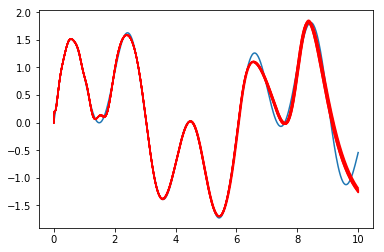

In [43]:
plt.plot(train_x, train_y.detach())
plt.plot(train_x, small_pert_preds.detach(), color="red")

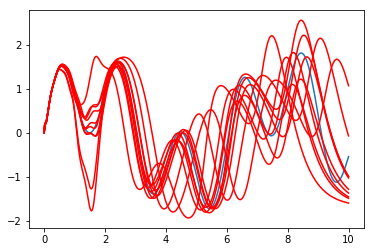

In [44]:
plt.plot(train_x, train_y.detach())
plt.plot(train_x, pert_preds.detach(), color="red")

In [38]:
test = optimus(train_x)

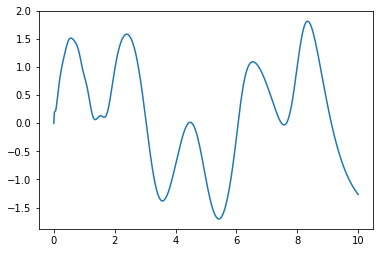

In [31]:
plt.plot(train_x, test.detach())